<a href="https://colab.research.google.com/github/Mingyuli1996/Stock-Price-Estimation/blob/master/Stock_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pykalman

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
from datetime import datetime, timedelta
from pykalman import KalmanFilter
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
%matplotlib inline

In [0]:
def reduce_noise(X):
#This function applys kalman filter to reduce the noise in daily stock price
    kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = X.values[0],
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)
    
    state_means,_ = kf.filter(X.values)
    state_means = state_means.flatten()
#     state_means=state_means.astype(int)
    return state_means

def get_prices(ticks, st, ed):
# This function gets Adjusted Closing prices from Yahoo Finance
# returns a DataFrame. Inputs are ticks (list of tickers), st (start date), ed (end date)
    for idx, ticker in enumerate(ticks):
        print(ticker)
        f = web.DataReader(ticker, 'yahoo', st, ed)['Adj Close']
        f.name = ticker
        if idx==0:
            df = f
        else:
            df = pd.concat([df, f], axis=1)
        return df


def denoise(data):
    ticks=list(data.columns) 
    for ticker in enumerate(ticks):
        print(ticker)
        f_clean=reduce_noise(data[ticker])
#         f_clean.name = ticker
        f_clean=pd.DataFrame(data=f_clean,index = data.index.values,columns=ticker)
#         f = web.DataReader(ticker, 'yahoo', st, ed)['Adj Close']
        data_clean = pd.concat([data_clean, f_clean], axis=1)
        return data_clean

In [0]:
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#get the data
start = dt.datetime(1979, 5, 1)
end   = dt.datetime(2019,5,3)

df = web.DataReader('IBM' , 'yahoo', start, end)
df_clean=reduce_noise(df['Adj Close'])
df_clean2=pd.DataFrame(data=df_clean,index = df.index.values,columns=['Close'])

In [0]:
# df = web.DataReader('IBM' , 'yahoo', start, end)
df_clean=reduce_noise(df['Adj Close'])
df_clean2=pd.DataFrame(data=df_clean,index = df.index.values,columns=['Close'])
#print the head

Text(0.5, 1.0, 'Price Trend from 2009 to 2019')

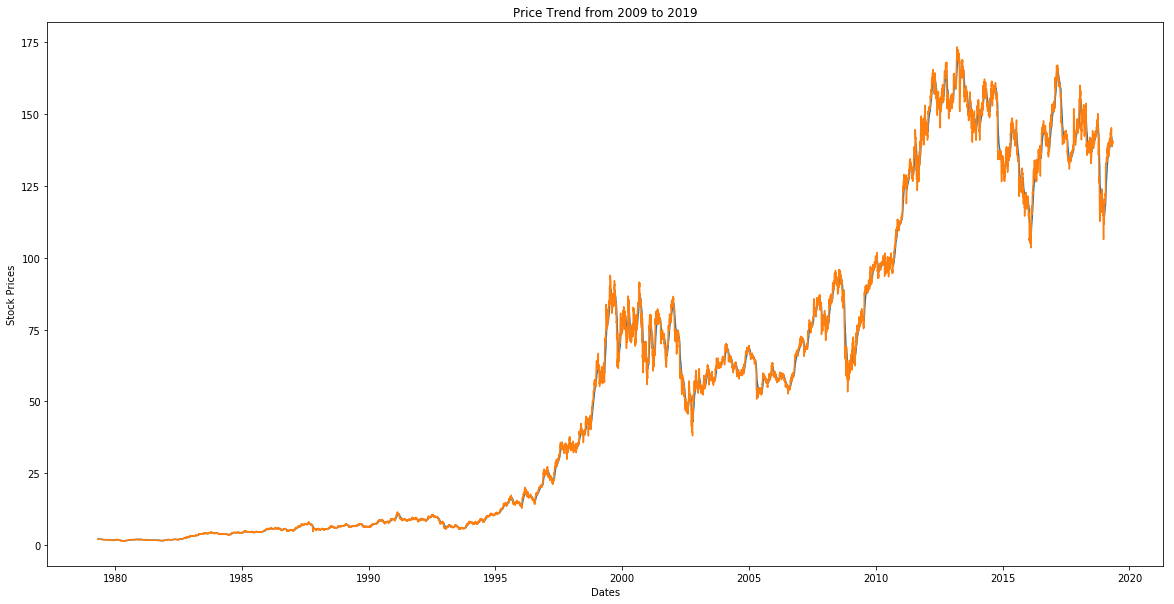

In [0]:
# plt.figure(figsize=(16,8))
# ax = df_clean2.rename(columns={"Close": "Denoised_price"}).plot(title='Random Forest predicted prices 8-2 years')


plt.plot(df_clean2['Close'])
plt.plot(df['Adj Close'])

# fig = df.rename(columns={"Adj Close": "Actual_price"}).plot(ax = ax).get_figure()

plt.xlabel("Dates")
plt.ylabel("Stock Prices")
plt.title('Price Trend from 2009 to 2019')

In [0]:
df_clean2['Date']=df.index

In [0]:
data = df_clean2.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values


In [0]:
train_start_date = '1979-05-01'
train_end_date = '2011-04-30'
test_start_date = '2011-05-01'
test_end_date = '2019-05-03'
train = df.ix[train_start_date : train_end_date]
test= df.ix[test_start_date:test_end_date]
print(train.shape,test.shape)

(8075, 6) (2015, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [0]:
train.shape

(8075, 6)

In [0]:
train = dataset[0:train.shape[0],:]
test = dataset[train.shape[0]:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
x_train, y_train = [], []
for i in range(0,len(train)):
    x_train=np.append(x_train,scaled_data[i,0])
    y_train=np.append(y_train,scaled_data[i+5,0])
    x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape , y_train.shape)

(8075,) (8075,)


In [0]:
# for i in range(i,len(train)):
#     x_train=np.append(x_train, scaled_data[i-60,0])
#     y_train=np.append(y_train, scaled_data[i,0])
#     x_train, y_train = np.array(x_train), np.array(y_train)
    


In [0]:
x_train = np.reshape(x_train, (x_train.shape[0],1,1))
# x_train

In [0]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(1,1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 30s - loss: 7.2845e-04


In [0]:
inputs = new_data[len(train):].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [0]:
X_test = []
y_test=[]
for i in range(5,inputs.shape[0]):
    X_test=np.append(X_test,inputs[i-5,0])
    y_test=np.append(y_test,inputs[i,0])
#     df_test=np.append(df2,(df['Adj Close'])
    X_test ,y_test= np.array(X_test), np.array(y_test)

In [0]:
print(X_test.shape , y_test.shape)

(2010,) (2010,)


In [0]:
X_test = np.reshape(X_test, (X_test.shape[0],1,1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
rms=np.sqrt(np.mean(np.power((test3-closing_price),2)))
rms

5.246866437971982

In [0]:
df2= pd.DataFrame(data=df['Adj Close'])
test2= df2.ix[test_start_date:test_end_date]
test3=np.array(test2.iloc[5:,:])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


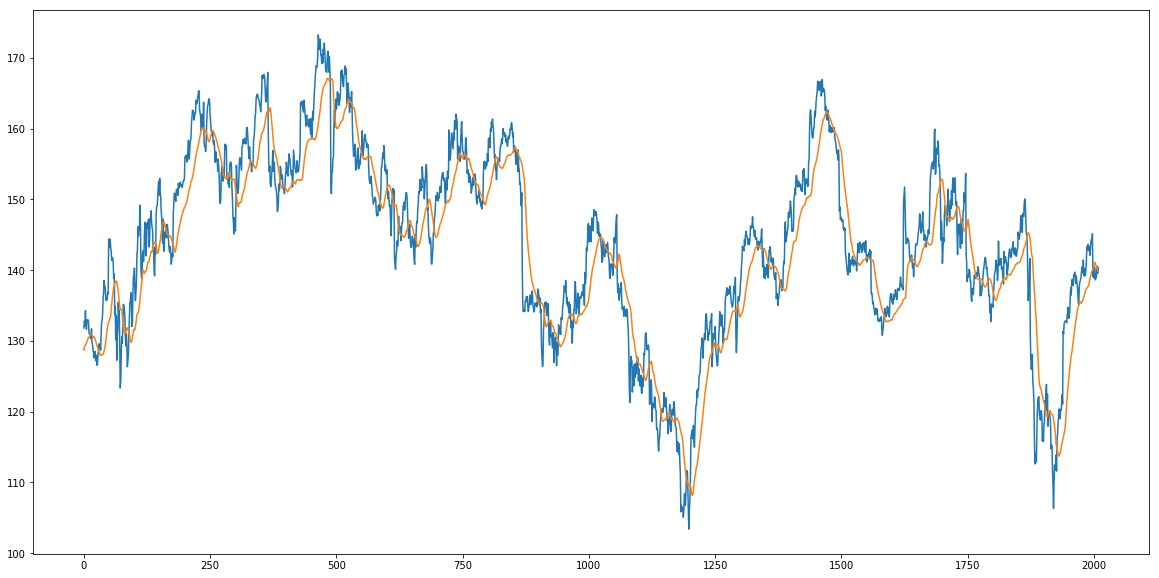

In [0]:
# # plt.plot(train['Adj Close'])
# plt.plot(train['Adj Close'])


plt.plot(test3)

# closing_price=pd.DataFrame(data=closing_price,index = test.index.values,columns=['Close'])
plt.plot(closing_price)

In [0]:
# #Compare the estimation with the denoised stock price
# plt.plot(closing_price['Close'])
# plt.plot(df_clean2.ix[test_start_date:test_end_date]['Close'])